In [1]:
%matplotlib notebook
import pandas as pd
import os 
from collections import OrderedDict
import time
import deepdish.io as dd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

from utils.inference import SVI
import utils.models as m
from utils.layers import *
from utils.inception import *
import utils.datasets as d

In [2]:
X = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=666)

In [4]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
train = d.H_alphaSequences(X_train, y_train)
test = d.H_alphaSequences(X_test, y_test)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size=512, shuffle=True)

# ResNetVAE

In [11]:
mod = m.ResNetVAE(channels=[32, 64, 64, 128], latent_space_dim=30, activation=nn.PReLU())

In [12]:
optimizer = torch.optim.Adam(mod.parameters(), lr=1e-3)

In [13]:
svi = SVI(
        vae_model=mod,
        optimizer=optimizer,
        loss_function="GaussianNLL",
        scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,200], gamma=0.1),
        tensorboard=True,
        model_name = "ResNetVAE_LeakyReLU_NLL_lr-{1e-3,1e-4,1e-5}_bs-512_ls-30",
        verbose=True
        )

cuda:0


In [14]:
lh = svi(epochs=300, train_loader=train_loader, validation_loader=test_loader, flatten=False)

Epoch [1/300], average_loss:89.0650, validation_loss:106.6711
Epoch [2/300], average_loss:-30.1875, validation_loss:-64.1087
Epoch [3/300], average_loss:-52.2348, validation_loss:-84.1390
Epoch [4/300], average_loss:-60.2805, validation_loss:-111.9645
Epoch [5/300], average_loss:-80.9580, validation_loss:-100.4456
Epoch [6/300], average_loss:-79.1465, validation_loss:-128.8758
Epoch [7/300], average_loss:-89.1581, validation_loss:-108.8722
Epoch [8/300], average_loss:-88.0437, validation_loss:-85.7496
Epoch [9/300], average_loss:-112.4086, validation_loss:-137.6970
Epoch [10/300], average_loss:-96.2929, validation_loss:-135.4127
Epoch [11/300], average_loss:-100.4669, validation_loss:-120.2700
Epoch [12/300], average_loss:-115.8707, validation_loss:-120.8284
Epoch [13/300], average_loss:-115.1019, validation_loss:-91.3909
Epoch [14/300], average_loss:-105.3620, validation_loss:-125.5751
Epoch [15/300], average_loss:-113.5541, validation_loss:-47.3822
Epoch [16/300], average_loss:-85.31

Epoch [126/300], average_loss:-225.3281, validation_loss:-228.9156
Epoch [127/300], average_loss:-231.1292, validation_loss:-242.7864
Epoch [128/300], average_loss:-232.1131, validation_loss:-217.1665
Epoch [129/300], average_loss:-229.4281, validation_loss:-243.6643
Epoch [130/300], average_loss:-223.7000, validation_loss:-220.9784
Epoch [131/300], average_loss:-224.9090, validation_loss:-236.8403
Epoch [132/300], average_loss:-227.5168, validation_loss:-223.7537
Epoch [133/300], average_loss:-230.5638, validation_loss:-247.3526
Epoch [134/300], average_loss:-228.5576, validation_loss:-242.1495
Epoch [135/300], average_loss:-227.7697, validation_loss:-246.8776
Epoch [136/300], average_loss:-228.7883, validation_loss:-244.8820
Epoch [137/300], average_loss:-220.6076, validation_loss:-219.6849
Epoch [138/300], average_loss:-231.7067, validation_loss:-244.6747
Epoch [139/300], average_loss:-233.2217, validation_loss:-233.5257
Epoch [140/300], average_loss:-229.9043, validation_loss:-246.

Epoch [249/300], average_loss:-251.2964, validation_loss:-257.4593
Epoch [250/300], average_loss:-250.9879, validation_loss:-257.7013
Epoch [251/300], average_loss:-251.6963, validation_loss:-256.8628
Epoch [252/300], average_loss:-249.8761, validation_loss:-252.3515
Epoch [253/300], average_loss:-249.2407, validation_loss:-251.9656
Epoch [254/300], average_loss:-250.0174, validation_loss:-255.4218
Epoch [255/300], average_loss:-252.6899, validation_loss:-255.8372
Epoch [256/300], average_loss:-250.5150, validation_loss:-256.2890
Epoch [257/300], average_loss:-251.8111, validation_loss:-257.5429
Epoch [258/300], average_loss:-252.1577, validation_loss:-256.1768
Epoch [259/300], average_loss:-251.0547, validation_loss:-257.0875
Epoch [260/300], average_loss:-252.3099, validation_loss:-255.5142
Epoch [261/300], average_loss:-251.2830, validation_loss:-256.7603
Epoch [262/300], average_loss:-251.4077, validation_loss:-252.0888
Epoch [263/300], average_loss:-251.8603, validation_loss:-256.

cuda:0


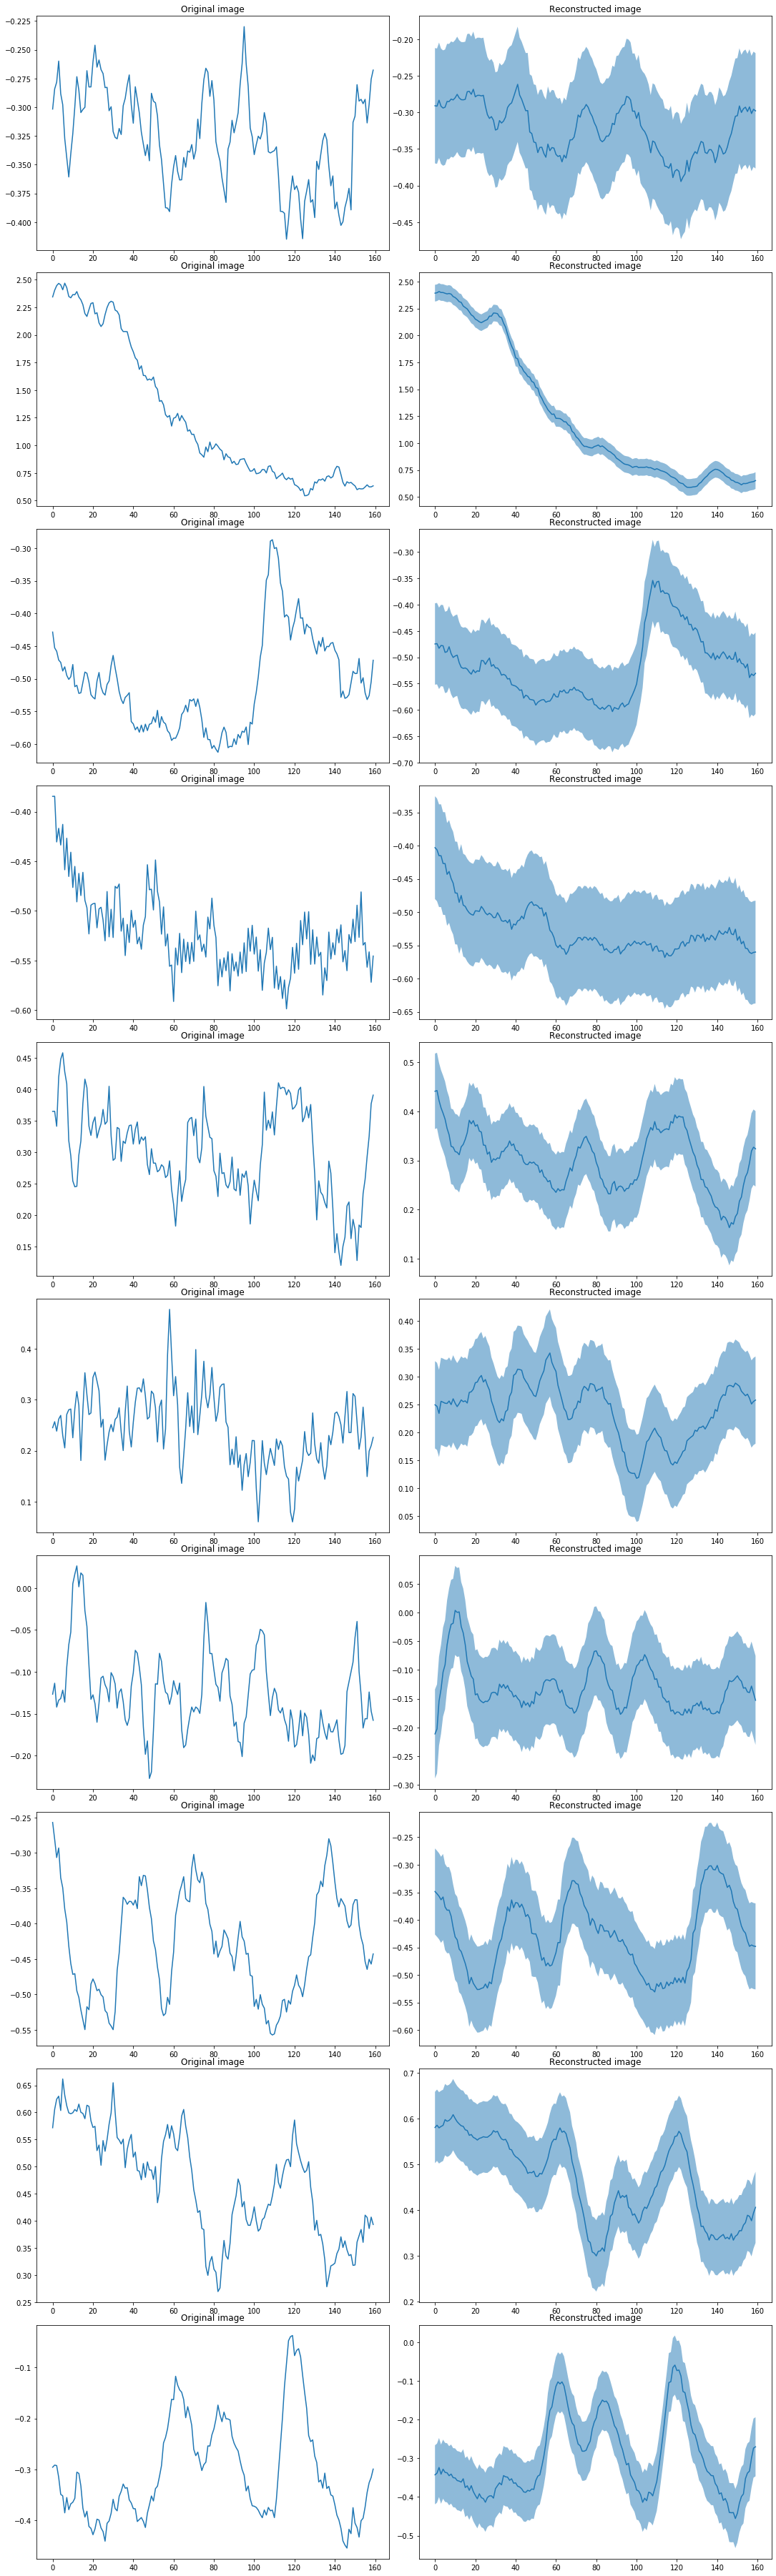

In [15]:
# epoch 300
print(svi.device)
X,_ = next(iter(test_loader))
output, mu, sigma = svi.model(X.to(svi.device))
#X_hat = output.cpu().detach().numpy()
mu_hat = output[0].cpu().detach().numpy()
sigma = output[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(X[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat[i])
    axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

In [16]:
#torch.save(svi.model, "models_and_losses/ResNetVAE_RReLU_NLL_lr-{1e-3,1e-4}_bs-512_ls-30_epoch-300.pt")
#torch.save(svi.model.state_dict(), "models_and_losses/ResNetVAE_RReLU_NLL_lr-{1e-3,1e-4}_bs-512_ls-30_epoch-300_state_dict.pt")
#torch.save(svi.optimizer, "models_and_losses/ResNetVAE_RReLU_NLL_lr-{1e-3,1e-4}_bs-512_ls-30_epoch-300_optimizer.pt")

C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNetVAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type PReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv1d. It won't be checked for correctness upon lo

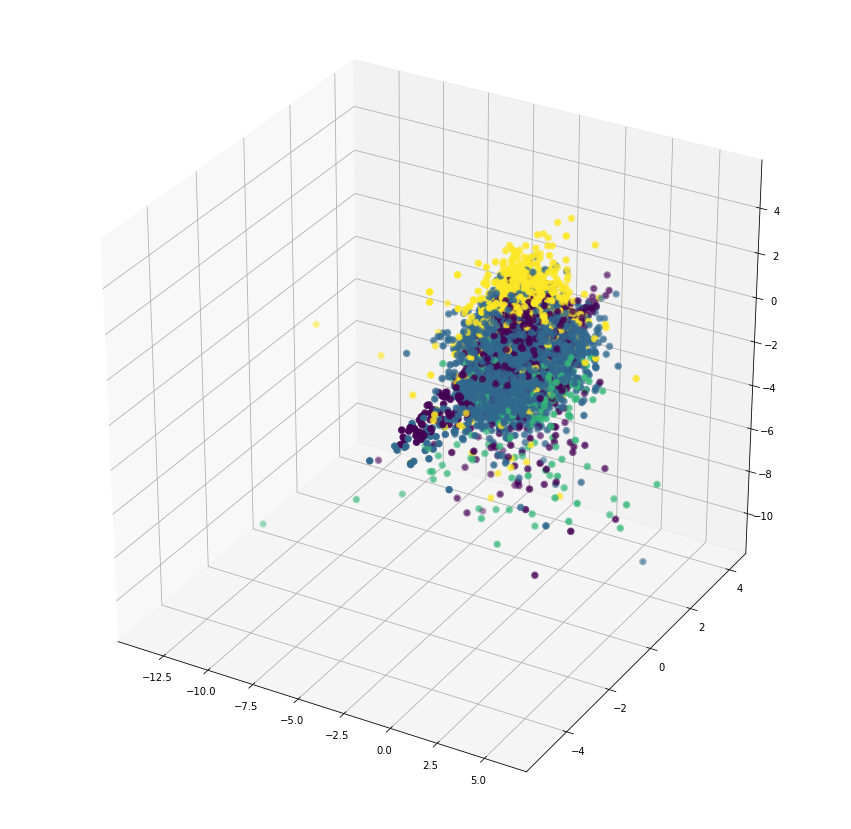

In [17]:
# epoch 300
X_1, cl = test.X, test.y
Z_hat, mu, sigma = svi.model.encoder(X_1.to(svi.device)) #.view(-1,28*28)
Z_hat = Z_hat.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(Z_hat[:,0], Z_hat[:,1], Z_hat[:,2], c=cl, lw=3)
sc = ax.scatter(mu[:,0], mu[:,1], mu[:,2], c=cl, lw=3)

# T-SNE

In [19]:
from sklearn.manifold import TSNE

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
model = m.ResNetVAE(channels=[32,64,64,128],latent_space_dim=30, activation=nn.PReLU())

In [10]:
model.load_state_dict(torch.load("models_and_losses/ResNetVAE_PReLU_NLL_lr-{1e-3,1e-4}_bs-512_ls-30_epoch-300_state_dict.pt"))

<All keys matched successfully>

In [16]:
X_1, cl = X_test, y_test
model.cuda()
Z_hat, mu, sigma = model.encoder(torch.tensor(X_1).float().cuda()) #.view(-1,28*28)
Z_hat = Z_hat.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()

In [17]:
#np.save("data/encoded_data_test_ResNetVAE_PReLU_NLL_lr-{1e-3,1e-4,1e-5}_bs-512_ls-30_epoch-300.npy", mu)

In [20]:
X_RN = TSNE(n_components=3, verbose=True).fit_transform(mu)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16736 samples in 0.055s...
[t-SNE] Computed neighbors for 16736 samples in 33.421s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16736
[t-SNE] Computed conditional probabilities for sample 2000 / 16736
[t-SNE] Computed conditional probabilities for sample 3000 / 16736
[t-SNE] Computed conditional probabilities for sample 4000 / 16736
[t-SNE] Computed conditional probabilities for sample 5000 / 16736
[t-SNE] Computed conditional probabilities for sample 6000 / 16736
[t-SNE] Computed conditional probabilities for sample 7000 / 16736
[t-SNE] Computed conditional probabilities for sample 8000 / 16736
[t-SNE] Computed conditional probabilities for sample 9000 / 16736
[t-SNE] Computed conditional probabilities for sample 10000 / 16736
[t-SNE] Computed conditional probabilities for sample 11000 / 16736
[t-SNE] Computed conditional probabilities for sample 12000 / 16736
[t-SNE] Computed conditional probabilities for sa

In [21]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [7]:
X_1, cl = X_test, y_test
X_RN = np.load("data/ResNet_PReLU_30_t-sne.npy")

<IPython.core.display.Javascript object>


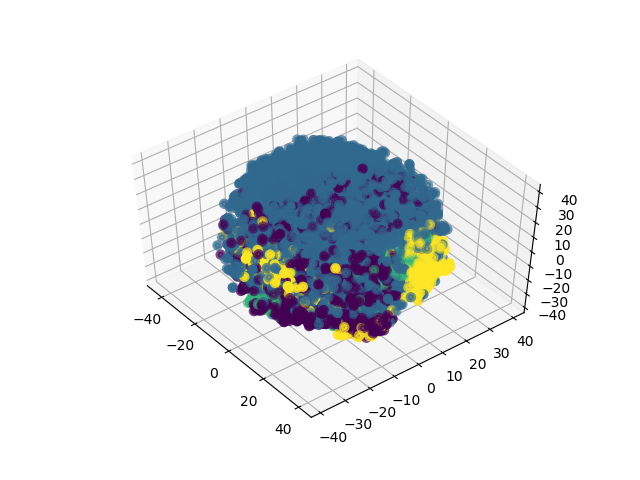

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_RN[:,1], X_RN[:,0], X_RN[:,2], c=cl, lw=3)


In [23]:
#np.save("data/ResNet_PReLU_30_t-sne.npy", X_RN)